<a href="https://colab.research.google.com/github/anslemhuncho/MACHINE-LEARNING-PROJECT/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['animals_protection', 'appealing_for_peace', 'brexit', 'covid19', 'election', 'environment_protection', 'gender_equality', 'immigration', 'racial_equality', 'yellow_vests_movement']

# Define paths to your train and test folders
train_path = '/content/drive/MyDrive/Normalised data/train'
test_path = '/content/drive/MyDrive/Normalised data/test'
saved_model_path = 'crowd_prediction_model.h5'  # Save to current folder

# Set up data generators with data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='categorical',  # Categorical classification for multiple classes
    shuffle=True,
    subset='training',
    classes=class_labels  # Use defined class labels
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='categorical',  # Categorical classification for multiple classes
    shuffle=False,
    subset='validation',
    classes=class_labels  # Use defined class labels
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='categorical',  # Categorical classification for multiple classes
    shuffle=False,
    classes=class_labels  # Use defined class labels
)

# Define a function to create your Keras model
def create_model(learning_rate=0.001, dropout_rate=0.5):
    # Load the pre-trained EfficientNetB0 model without the top layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(254, 254, 3))

    # Add a global average pooling layer and a dense layer for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(len(class_labels), activation='softmax')(x)  # Softmax for multi-class classification

    # Create the model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with the specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a KerasClassifier wrapper for your Keras model
keras_model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(keras_model, param_grid, cv=3, n_iter=5, verbose=1)

# Train the model with hyperparameter tuning
random_search.fit(train_generator, epochs=25, validation_data=validation_generator)

# Evaluate the best model on the test data
test_loss, test_accuracy = random_search.best_estimator_.model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

# Save the best model
random_search.best_estimator_.model.save(saved_model_path)

# Plot training history
plt.plot(random_search.best_estimator_.model.history.history['accuracy'], label='accuracy')
plt.plot(random_search.best_estimator_.model.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions from the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Collect true labels
true_classes = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print other evaluation metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save the confusion matrix as an image
plt.show()

65/65 [==============================] - 12s 170ms/step
Confusion Matrix:
[[282   0   0   0   0   0   0   0   0   0]
 [287   0   0   0   0   0   0   0   0   0]
 [285   0   0   0   0   0   0   0   0   0]
 [143   0   0   0   0   0   0   0   0   0]
 [216   0   0   0   0   0   0   0   0   0]
 [193   0   0   0   0   0   0   0   0   0]
 [146   0   0   0   0   0   0   0   0   0]
 [182   0   0   0   0   0   0   0   0   0]
 [163   0   0   0   0   0   0   0   0   0]
 [172   0   0   0   0   0   0   0   0   0]]
Accuracy: 0.1362977283711938
Precision: 0.01857707075914773
Recall: 0.1362977283711938
F1-score: 0.03269754096186869


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'class_labels' is not defined

<Figure size 1000x800 with 0 Axes>

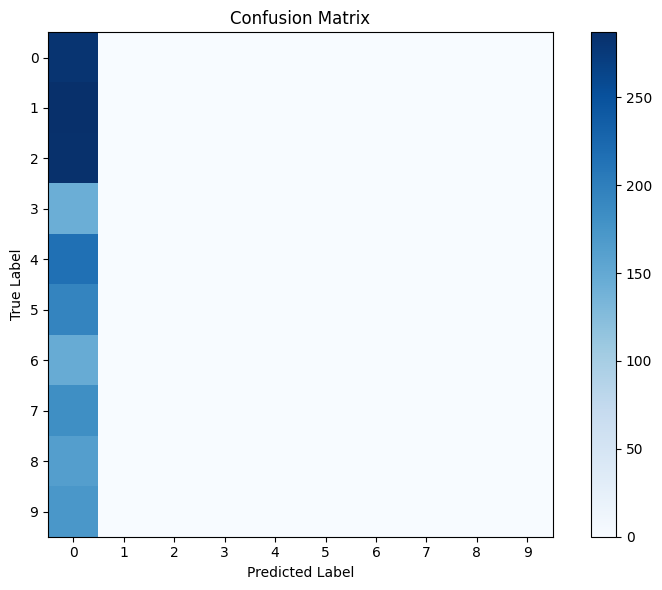

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the data as a numpy array
data = np.array([[282, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [287, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [285, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [143, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [216, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [193, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [146, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [182, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [163, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [172, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(data, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(10)
plt.xticks(tick_marks, np.arange(10))
plt.yticks(tick_marks, np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the plot
plt.tight_layout()
plt.show()

